# Import

In [49]:
!pip install torch
!pip install transformers
!pip install sklearn-crfsuite

In [50]:
import pickle
import operator
import re
import string
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import ast
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import CRF
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, recall_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input , models , layers
from tensorflow.keras.layers import LSTM, Embedding, Dense
from keras.models import Sequential
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import  Conv1D, MaxPooling1D, Dropout

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa

import spacy

# Data

geo = Geographical Entity

org = Organization

per = Person

gpe = Geopolitical Entity

tim = Time indicator

art = Artifact

eve = Event

nat = Natural Phenomenon

In [52]:
df = pd.read_csv('ner.csv')
df.head()

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


# EDA

In [53]:
df.describe()

,text,labels
count,47959,47959
unique,47575,33318
top,VOA 's Mil Arcega reports .,O O O O O O O O O O O
freq,17,450


В столбце text имеется 47575 уникальных значений, что означает, что большая часть текстов различается, и только небольшое количество из них повторяется.
В столбце labels 33318 уникальных значений говорит о том, что эти метки разнообразны.

В столбце text самое частое значение — это "VOA 's Mil Arcega reports.", которое повторяется 17 раз. Это может указывать на то, что в данных есть много похожих или повторяющихся текстов.
В столбце labels наиболее часто встречающееся значение встречается 450 раз, что говорит о том, что одна из меток является значительно более распространенной, чем другие.

In [54]:
df.isna().sum()

text      0
labels    0
dtype: int64

В данных нет пропущенных значений

In [55]:
label_counts = df['labels'].apply(lambda x: x.split()).explode().value_counts()
print(label_counts)

labels
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64


C:\Users\admin\AppData\Local\Temp\ipykernel_11036\2419533347.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


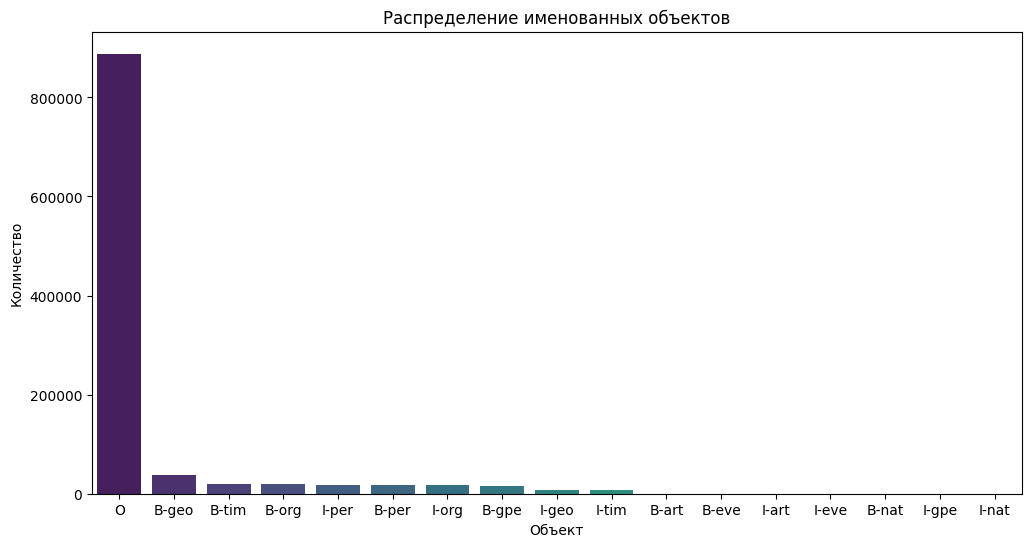

In [56]:
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title("Распределение именованных объектов")
plt.xlabel("Объект")
plt.ylabel("Количество")
plt.show()

Метка "O" значительно преобладает, что может указывать на то, что большая часть текста не содержит сущностей. Исключим O, чтобы посмотреть как распределены именованные объекты

C:\Users\admin\AppData\Local\Temp\ipykernel_11036\873875769.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=entity_counts.index, y=entity_counts.values, palette='viridis')


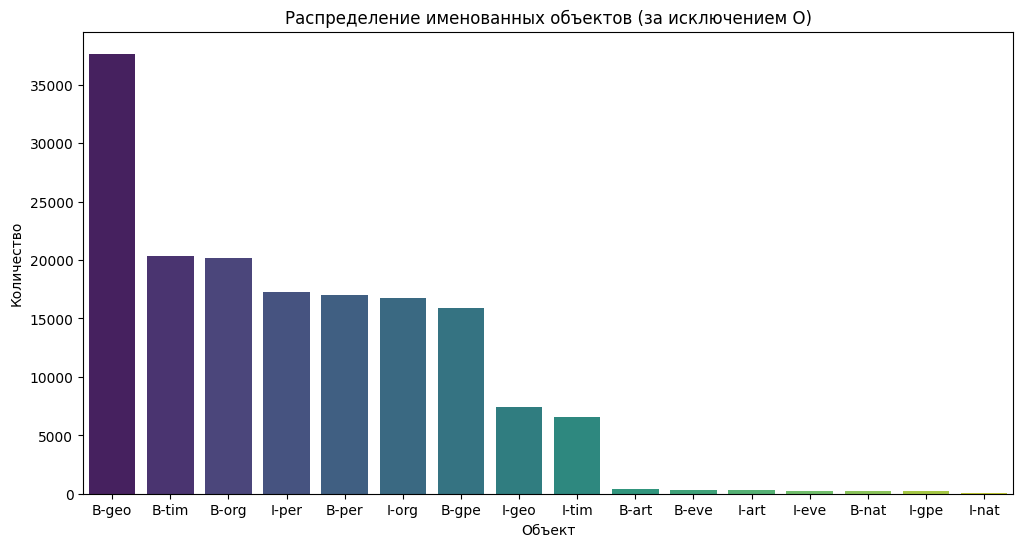

In [57]:
entity_counts = df['labels'].apply(lambda x: x.split()).explode().value_counts()
entity_counts = entity_counts[entity_counts.index != 'O']

plt.figure(figsize=(12, 6))
sns.barplot(x=entity_counts.index, y=entity_counts.values, palette='viridis')
plt.title("Распределение именованных объектов (за исключением O)")
plt.xlabel("Объект")
plt.ylabel("Количество")
plt.show()

В данных присутствует множество различных меток, что говорит о разнообразности текста.
В тексте большое преобладают упоминания для Geographical Entity, Organization, Person, Geopolitical Entity, Time indicator, тогда как  Artifact, Event, Natural Phenomenon встречаются реже.

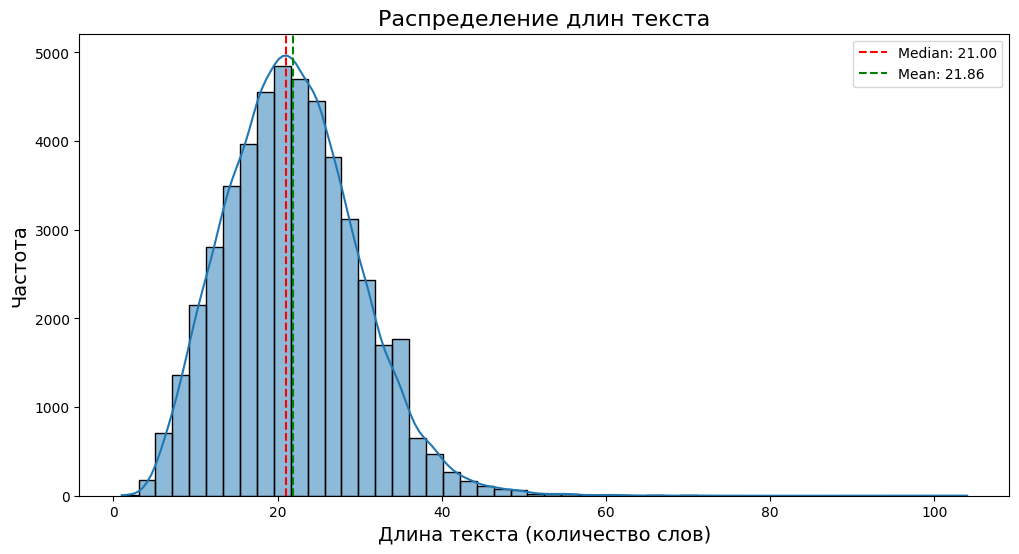

In [58]:
text_lengths = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(text_lengths, bins=50, kde=True)

median_length = text_lengths.median()
mean_length = text_lengths.mean()

plt.axvline(median_length, color='red', linestyle='--', label=f'Median: {median_length:.2f}')
plt.axvline(mean_length, color='green', linestyle='--', label=f'Mean: {mean_length:.2f}')

plt.title("Распределение длин текста", fontsize=16)
plt.xlabel("Длина текста (количество слов)", fontsize=14)
plt.ylabel("Частота", fontsize=14)

plt.legend()

plt.show()

In [59]:
MAX_SENTENCE = text_lengths.max()
MAX_SENTENCE

104

In [60]:
text_lengths.min()

1

Среднее предложение в наборе данных содержит 21 слово, тогда как самое короткое состоит из одного слова, а самое длинное из 104 слов.

### Data Preparation and Cleaning

In [61]:
df.duplicated().sum()

349

В данных есть повторения, удалим их

In [62]:
df = df.drop_duplicates().copy()
print(df.duplicated().sum())
df

0


,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...
...,...,...
47954,Opposition leader Mir Hossein Mousavi has said...,O O O B-per I-per O O O O O O O O O O O O O O ...
47955,"On Thursday , Iranian state media published a ...",O B-tim O B-gpe O O O O O O O O B-org I-org O ...
47956,"Following Iran 's disputed June 12 elections ,...",O B-geo O O B-tim I-tim O O O O O O O O O O O ...
47957,"Since then , authorities have held public tria...",O O O O O O O O O O O O O O O O O O O O O


In [63]:
def clean_text(text):

    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

df['clean_text'] = df['text'].apply(clean_text)

In [64]:
df

,text,labels,clean_text
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,thousands demonstrators marched london protest...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...,iranian officials say expect get access sealed...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...,helicopter gunships saturday pounded militant ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O,left tense hour-long standoff riot police .
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...,u.n. relief coordinator jan egeland said sunda...
...,...,...,...
47954,Opposition leader Mir Hossein Mousavi has said...,O O O B-per I-per O O O O O O O O O O O O O O ...,opposition leader mir hossein mousavi said pla...
47955,"On Thursday , Iranian state media published a ...",O B-tim O B-gpe O O O O O O O O B-org I-org O ...,"thursday , iranian state media published messa..."
47956,"Following Iran 's disputed June 12 elections ,...",O B-geo O O B-tim I-tim O O O O O O O O O O O ...,"following iran 's disputed june 12 elections ,..."
47957,"Since then , authorities have held public tria...",O O O O O O O O O O O O O O O O O O O O O,"since , authorities held public trials accused..."


### Токенезация

In [65]:
df['text_tokens'] = df['text'].apply(lambda x: x.split())
df['clean_text_tokens'] = df['clean_text'].apply(lambda x: x.split())
df['label_tokens'] = df['labels'].apply(lambda x: x.split())

In [66]:
alignment_check = df.apply(lambda row: len(row['text_tokens']) == len(row['label_tokens']), axis=1)
print("Проверка выравнивания:", alignment_check.all())

Проверка выравнивания: False


In [67]:
alignment_issues = df[df.apply(lambda row: len(row['text_tokens']) != len(row['label_tokens']), axis=1)].copy()
df = df.drop(alignment_issues.index)
df.reset_index(drop=True, inplace=True)

alignment_check = df.apply(lambda row: len(row['text_tokens']) == len(row['label_tokens']), axis=1)
print("Проверка выравнивания:", alignment_check.all())

Проверка выравнивания: True


In [68]:
alignment_check = df.apply(lambda row: len(row['clean_text_tokens']) == len(row['label_tokens']), axis=1)
print("Проверка выравнивания:", alignment_check.all())

Проверка выравнивания: False


In [69]:
alignment_issues = df[df.apply(lambda row: len(row['clean_text_tokens']) != len(row['label_tokens']), axis=1)].copy()
df = df.drop(alignment_issues.index)
df.reset_index(drop=True, inplace=True)

alignment_check = df.apply(lambda row: len(row['clean_text_tokens']) == len(row['label_tokens']), axis=1)
print("Проверка выравнивания:", alignment_check.all())

Проверка выравнивания: True


In [70]:
df.to_csv('data.csv', index=False)

# Neural Networks

In [71]:
df = pd.read_csv('data.csv')

In [72]:
df

,text,labels,clean_text,text_tokens,clean_text_tokens,label_tokens
0,Brian Allen narrates .,B-per I-per O O,brian allen narrates .,"['Brian', 'Allen', 'narrates', '.']","['brian', 'allen', 'narrates', '.']","['B-per', 'I-per', 'O', 'O']"
1,VOA 's Alex Villarreal reports .,B-org O B-per I-per O O,voa 's alex villarreal reports .,"['VOA', ""'s"", 'Alex', 'Villarreal', 'reports',...","['voa', ""'s"", 'alex', 'villarreal', 'reports',...","['B-org', 'O', 'B-per', 'I-per', 'O', 'O']"
2,VOA 's Carol Pearson reports .,B-org O B-per I-per O O,voa 's carol pearson reports .,"['VOA', ""'s"", 'Carol', 'Pearson', 'reports', '.']","['voa', ""'s"", 'carol', 'pearson', 'reports', '.']","['B-org', 'O', 'B-per', 'I-per', 'O', 'O']"
3,VOA 's Mandy Clark reports .,B-org O B-per I-per O O,voa 's mandy clark reports .,"['VOA', ""'s"", 'Mandy', 'Clark', 'reports', '.']","['voa', ""'s"", 'mandy', 'clark', 'reports', '.']","['B-org', 'O', 'B-per', 'I-per', 'O', 'O']"
4,Paul Sisco reports .,B-per I-per O O,paul sisco reports .,"['Paul', 'Sisco', 'reports', '.']","['paul', 'sisco', 'reports', '.']","['B-per', 'I-per', 'O', 'O']"
...,...,...,...,...,...,...
95,Winds reached well past 200 kilometers per hour .,O O O O O O O O O,winds reached well past 200 kilometers per hour .,"['Winds', 'reached', 'well', 'past', '200', 'k...","['winds', 'reached', 'well', 'past', '200', 'k...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
96,One victim remains unidentified .,O O O O O,one victim remains unidentified .,"['One', 'victim', 'remains', 'unidentified', '.']","['one', 'victim', 'remains', 'unidentified', '.']","['O', 'O', 'O', 'O', 'O']"
97,VOA 's Nathan King reports .,B-org O B-per I-per O O,voa 's nathan king reports .,"['VOA', ""'s"", 'Nathan', 'King', 'reports', '.']","['voa', ""'s"", 'nathan', 'king', 'reports', '.']","['B-org', 'O', 'B-per', 'I-per', 'O', 'O']"
98,Leatherback turtles fascinate ocean researchers .,O O O O O O,leatherback turtles fascinate ocean researchers .,"['Leatherback', 'turtles', 'fascinate', 'ocean...","['leatherback', 'turtles', 'fascinate', 'ocean...","['O', 'O', 'O', 'O', 'O', 'O']"


In [73]:
def process_row(row):
    words, tags, sentences = [], [], []
    text_tokens = ast.literal_eval(row['clean_text_tokens'])
    label_tokens = ast.literal_eval(row['label_tokens'])
    
    current_sentence = 0
    current_words = []
    current_tags = []

    for text_token, label_token in zip(text_tokens, label_tokens):
        
        current_words.append(text_token)
        current_tags.append(label_token)

       
        if text_token.endswith('.'):
            
            sentences.extend([f"Sentence: {current_sentence}"] * len(current_words))
            words.extend(current_words)
            tags.extend(current_tags)

            current_sentence += 1
            current_words = []
            current_tags = []

    if current_words:
        sentences.extend([f"Sentence: {current_sentence}"] * len(current_words))
        words.extend(current_words)
        tags.extend(current_tags)

    return sentences, words, tags

all_sentences = []
all_words = []
all_tags = []

for index, row in df.iterrows():
    sentences, words, tags = process_row(row)
    all_sentences.extend(sentences)
    all_words.extend(words)
    all_tags.extend(tags)

new_df_clean = pd.DataFrame({
    'Sentence #': all_sentences,
    'Word': all_words,
    'Tag': all_tags
})

new_df_clean


,Sentence #,Word,Tag
0,Sentence: 0,brian,B-per
1,Sentence: 0,allen,I-per
2,Sentence: 0,narrates,O
3,Sentence: 0,.,O
4,Sentence: 0,voa,B-org
...,...,...,...
632,Sentence: 1,bush,I-per
633,Sentence: 1,arrives,O
634,Sentence: 1,late,O
635,Sentence: 1,sunday,B-tim


In [74]:
new_df_clean.to_csv('new_df_clean.csv', index=False)

In [75]:
def process_row(row):
    words, tags, sentences = [], [], []
    text_tokens = ast.literal_eval(row['text_tokens'])
    label_tokens = ast.literal_eval(row['label_tokens'])
    
    current_sentence = 0
    current_words = []
    current_tags = []

    for text_token, label_token in zip(text_tokens, label_tokens):
        
        current_words.append(text_token)
        current_tags.append(label_token)

       
        if text_token.endswith('.'):
            
            sentences.extend([f"Sentence: {current_sentence}"] * len(current_words))
            words.extend(current_words)
            tags.extend(current_tags)

            current_sentence += 1
            current_words = []
            current_tags = []

    if current_words:
        sentences.extend([f"Sentence: {current_sentence}"] * len(current_words))
        words.extend(current_words)
        tags.extend(current_tags)

    return sentences, words, tags

all_sentences = []
all_words = []
all_tags = []

for index, row in df.iterrows():
    sentences, words, tags = process_row(row)
    all_sentences.extend(sentences)
    all_words.extend(words)
    all_tags.extend(tags)

new_df = pd.DataFrame({
    'Sentence #': all_sentences,
    'Word': all_words,
    'Tag': all_tags
})

new_df


,Sentence #,Word,Tag
0,Sentence: 0,Brian,B-per
1,Sentence: 0,Allen,I-per
2,Sentence: 0,narrates,O
3,Sentence: 0,.,O
4,Sentence: 0,VOA,B-org
...,...,...,...
632,Sentence: 1,Bush,I-per
633,Sentence: 1,arrives,O
634,Sentence: 1,late,O
635,Sentence: 1,Sunday,B-tim


In [76]:
new_df.to_csv('new_df.csv', index=False)

In [77]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        
        agg_func = lambda s: [(w, t) for w, t in zip(s['Word'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        if self.n_sent <= len(self.sentences):
            s = self.sentences[self.n_sent - 1]
            self.n_sent += 1
            return s
        return None
    
    def has_next(self):
        """Проверка, есть ли еще предложения для получения."""
        return self.n_sent <= len(self.sentences)


In [78]:
getter_clean = SentenceGetter(new_df_clean)
sentences_clean = getter_clean.sentences

C:\Users\admin\AppData\Local\Temp\ipykernel_11036\2520769341.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby('Sentence #').apply(agg_func)


In [79]:
getter = SentenceGetter(new_df)
sentences = getter.sentences

C:\Users\admin\AppData\Local\Temp\ipykernel_11036\2520769341.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby('Sentence #').apply(agg_func)


In [80]:
def word2features(sent, i):
    word = sent[i][0]
    label = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:], 
        'word[-2:]': word[-2:], 
        'word.isupper()': word.isupper(), 
        'word.istitle()': word.istitle(), 
        'word.isdigit()': word.isdigit(),
        'label': label,
        'word.length': len(word),
        'word.vowel.count': sum(1 for char in word.lower() if char in 'aeiou'),
        'word.consonant.count': sum(1 for char in word.lower() if char.isalpha() and char not in 'aeiou'),
    }

    if i > 0:
        word1 = sent[i-1][0]
        label1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:label': label1,
            '-1:word.length': len(word1),
        })
        
    if i > 1:
        word2 = sent[i-2][0]
        features['-2:word.lower()'] = word2.lower()
        
    if i < len(sent) - 1:
        word1 = sent[i + 1][0]
        label1 = sent[i + 1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:label': label1,
            '+1:word.length': len(word1),
        })


    if i < len(sent) - 2:
        word2 = sent[i + 2][0]
        features['+2:word.lower()'] = word2.lower()

    if i == 0:
        features['BOS'] = True
    if i == len(sent) - 1:
        features['EOS'] = True

    return features

def sent2features(sent):
    """Преобразует предложение в список функций для каждого токена."""
    return [word2features(sent, i) for i, _ in enumerate(sent)]

def sent2labels(sent):
    """Извлекает метки из предложения."""
    return [label for _, label in sent]

def sent2tokens(sent):
    """Извлекает токены из предложения."""
    return [token for token, _ in sent]



In [81]:
X_clean = [sent2features(s) for s in sentences_clean]
y_clean = [sent2labels(s) for s in sentences_clean]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [83]:
param_dist = {
    'c1': [0, 0.1, 0.2, 0.5, 0.8, 1],
    'c2': [0, 0.1, 0.2, 0.5, 0.8, 1],
    'max_iterations': [100, 150, 200, 250, 300, 350, 400],
    'all_possible_transitions': [True, False]
}

crf = CRF(algorithm='lbfgs')

search = RandomizedSearchCV(crf, param_distributions=param_dist, n_iter=40, cv=2, verbose=2, n_jobs=6)

search.fit(X_train, y_train)

y_pred = search.predict(X_test)

y_true = [item for sublist in y_test for item in sublist]
y_pred_flat = [item for sublist in y_pred for item in sublist]

f1 = f1_score(y_true, y_pred_flat, average='weighted')
recall = recall_score(y_true, y_pred_flat, average='weighted')

print("Лучшие параметры:", search.best_params_)
print("Лучший балл:", search.best_score_)

print("f1",f1)
print("recall", recall)

print(classification_report(y_true, y_pred_flat, labels=label_counts.index))


Fitting 2 folds for each of 40 candidates, totalling 80 fits
Лучшие параметры: {'max_iterations': 350, 'c2': 0.1, 'c1': 0.2, 'all_possible_transitions': True}
Лучший балл: 0.8936170212765957
f1 0.6957151609839781
recall 0.7692307692307693
              precision    recall  f1-score   support

           O       0.81      1.00      0.90       417
       B-geo       0.44      0.18      0.26        22
       B-tim       1.00      0.29      0.44         7
       B-org       0.00      0.00      0.00        25
       I-per       0.43      0.58      0.50        45
       B-per       1.00      0.02      0.04        55
       I-org       0.00      0.00      0.00         3
       B-gpe       0.00      0.00      0.00        10
       I-geo       0.00      0.00      0.00         0
       I-tim       0.00      0.00      0.00         0
       B-art       0.00      0.00      0.00         0
       B-eve       0.00      0.00      0.00         1
       I-art       0.00      0.00      0.00         0
    

c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

In [84]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
param_dist = {
    'c1': [0, 0.1, 0.2, 0.5, 0.8, 1],
    'c2': [0, 0.1, 0.2, 0.5, 0.8, 1],
    'max_iterations': [100, 150, 200, 250, 300, 350, 400],
    'all_possible_transitions': [True, False]
}

crf = CRF(algorithm='lbfgs')

search = RandomizedSearchCV(crf, param_distributions=param_dist, n_iter=40, cv=2, verbose=2, n_jobs=6)

search.fit(X_train, y_train)

y_pred = search.predict(X_test)

y_true = [item for sublist in y_test for item in sublist]
y_pred_flat = [item for sublist in y_pred for item in sublist]

f1 = f1_score(y_true, y_pred_flat, average='weighted')
recall = recall_score(y_true, y_pred_flat, average='weighted')

print("Лучшие параметры:", search.best_params_)
print("Лучший балл:", search.best_score_)

print("f1",f1)
print("recall", recall)

print(classification_report(y_true, y_pred_flat, labels=label_counts.index))


Fitting 2 folds for each of 40 candidates, totalling 80 fits
Лучшие параметры: {'max_iterations': 350, 'c2': 0, 'c1': 0, 'all_possible_transitions': True}
Лучший балл: 0.925531914893617
f1 0.6305633493228241
recall 0.7025641025641025
              precision    recall  f1-score   support

           O       0.77      0.96      0.86       417
       B-geo       0.29      0.09      0.14        22
       B-tim       0.67      0.86      0.75         7
       B-org       0.00      0.00      0.00        25
       I-per       0.02      0.02      0.02        45
       B-per       1.00      0.02      0.04        55
       I-org       0.00      0.00      0.00         3
       B-gpe       0.00      0.00      0.00        10
       I-geo       0.00      0.00      0.00         0
       I-tim       0.00      0.00      0.00         0
       B-art       0.00      0.00      0.00         0
       B-eve       0.00      0.00      0.00         1
       I-art       0.00      0.00      0.00         0
       I-

c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

CRF плохо предсказывает малочисленные сущности, попробуем взять модель с  LSTM-слоями. При этом очистка и приведение к нижнему регистру ухудшила результаты, поэтому дальше будем работать с данными без очистки.

In [87]:
words = list(set(new_df['Word'].values))
words.append('ENDPAD')
num_words = len(words)
tags = list(set(new_df['Tag'].values))
num_tags = len(tags)
num_words, num_tags

(400, 9)

In [88]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [89]:
max_len = 100
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences] 
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim=num_words, output_dim=max_len)(input_word)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 100)          40000     
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 200)          160800    
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 100, 9)            1809      
 stributed)                                                      
                                                                 
Total params: 202609 (791.44 KB)
Trainable params: 202609 (791.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 5,
    verbose = 1,
    callbacks = callbacks
)


Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 2.1955 - accuracy: 0.1400 - val_loss: 2.1201 - val_accuracy: 0.9900
Epoch 2/5
1/1 [==============================] - 0s 295ms/step - loss: 2.1452 - accuracy: 0.8900 - val_loss: 2.0385 - val_accuracy: 0.9900


In [93]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print("Тренировочная потеря:", train_loss)
print("Тренировочная точность:", train_accuracy)
print("Валидационная потеря:", val_loss)
print("Валидационная точность:", val_accuracy)


Тренировочная потеря: [2.1954925060272217, 2.14518141746521]
Тренировочная точность: [0.14000000059604645, 0.8899999856948853]
Валидационная потеря: [2.120121955871582, 2.038546085357666]
Валидационная точность: [0.9900000095367432, 0.9900000095367432]


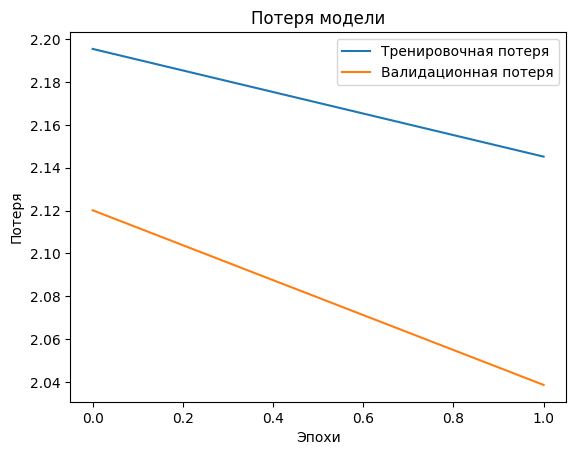

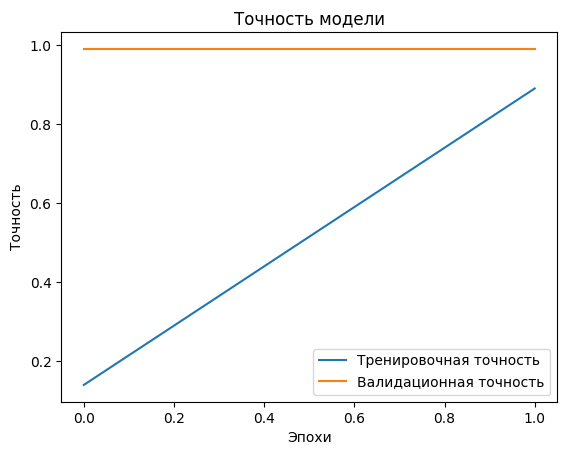

In [94]:
# Визуализация потерь
plt.plot(train_loss, label='Тренировочная потеря')
plt.plot(val_loss, label='Валидационная потеря')
plt.title('Потеря модели')
plt.ylabel('Потеря')
plt.xlabel('Эпохи')
plt.legend()
plt.show()

# Визуализация точности
plt.plot(train_accuracy, label='Тренировочная точность')
plt.plot(val_accuracy, label='Валидационная точность')
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпохи')
plt.legend()
plt.show()


In [95]:
# Получаем предсказания модели
predictions = model.predict(X_test)

# Преобразовываем предсказания в класс
predicted_classes = np.argmax(predictions, axis=-1)  
true_classes = np.argmax(np.array(y_test), axis=-1) 

f1 = f1_score(true_classes.flatten(), predicted_classes.flatten(), average='weighted')
recall = recall_score(true_classes.flatten(), predicted_classes.flatten(), average='weighted')

print('F1 Score:', f1)
print('Recall:', recall)


1/1 [==============================] - 1s 505ms/step
F1 Score: 0.6245086705202312
Recall: 0.73


In [96]:
report = classification_report(true_classes.flatten(), predicted_classes.flatten(), zero_division=0)
print("Classification Report \n", report)


Classification Report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        10
           3       0.74      0.99      0.84        74
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         1

    accuracy                           0.73       100
   macro avg       0.09      0.12      0.11       100
weighted avg       0.55      0.73      0.62       100



Добавим слой LSTM, Dropout, добавим веса классам

In [97]:
class_labels = np.unique(label_counts.index)
weights = 1/label_counts.values
class_weights = dict(enumerate(weights))

In [114]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim=num_words, output_dim=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 100, 100)          40000     
                                                                 
 spatial_dropout1d_3 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_11 (Bidirect  (None, 100, 200)          160800    
 ional)                                                          
                                                                 
 bidirectional_12 (Bidirect  (None, 100, 200)          240800    
 ional)                                                          
                                                           

In [120]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
#callbacks = [early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 128,
    epochs = 30,
    verbose = 1,
    #callbacks = callbacks,
    class_weight=class_weights
)


Epoch 1/30
1/1 [==============================] - 17s 17s/step - loss: 3.0739e-05 - accuracy: 0.9000 - val_loss: 0.1282 - val_accuracy: 0.9900
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 3.0477e-05 - accuracy: 0.9000 - val_loss: 0.1287 - val_accuracy: 0.9900
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 3.0370e-05 - accuracy: 0.9000 - val_loss: 0.1295 - val_accuracy: 0.9900
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 3.0428e-05 - accuracy: 0.9000 - val_loss: 0.1303 - val_accuracy: 0.9900
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 3.0149e-05 - accuracy: 0.9000 - val_loss: 0.1311 - val_accuracy: 0.9900
Epoch 6/30
1/1 [==============================] - 2s 2s/step - loss: 2.9922e-05 - accuracy: 0.9000 - val_loss: 0.1317 - val_accuracy: 0.9900
Epoch 7/30
1/1 [==============================] - 2s 2s/step - loss: 3.0107e-05 - accuracy: 0.9000 - val_loss: 0.1324 - val_accuracy: 0.9900
Epoch 8/30


In [121]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print("Тренировочная потеря:", train_loss)
print("Тренировочная точность:", train_accuracy)
print("Валидационная потеря:", val_loss)
print("Валидационная точность:", val_accuracy)


Тренировочная потеря: [3.0739320209249854e-05, 3.0477074687951244e-05, 3.0369679734576494e-05, 3.042766547878273e-05, 3.0148970836307853e-05, 2.992224835907109e-05, 3.01072886941256e-05, 2.9720118618570268e-05, 2.9411879950203e-05, 2.9357684979913756e-05, 2.9317363441805355e-05, 2.915231561928522e-05, 2.8830223527620547e-05, 2.8865035346825607e-05, 2.8447895601857454e-05, 2.8537786420201883e-05, 2.809741818055045e-05, 2.798664900183212e-05, 2.80398362519918e-05, 2.7804611818282865e-05, 2.76271857728716e-05, 2.7565527489059605e-05, 2.740302988968324e-05, 2.7105164917884395e-05, 2.6910714950645342e-05, 2.6622945370036177e-05, 2.6715984859038144e-05, 2.6840540158445947e-05, 2.6547890229267068e-05, 2.6320736651541665e-05]
Тренировочная точность: [0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.89999

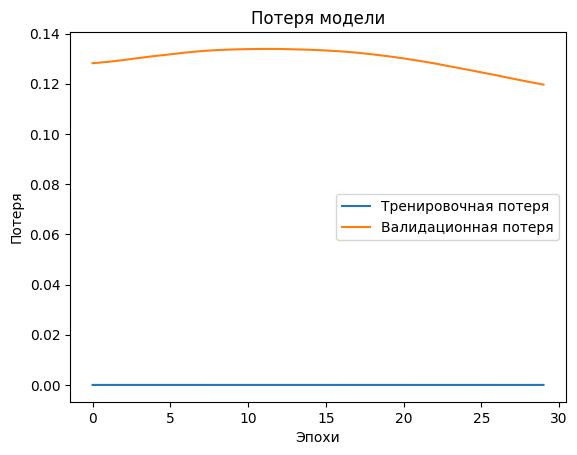

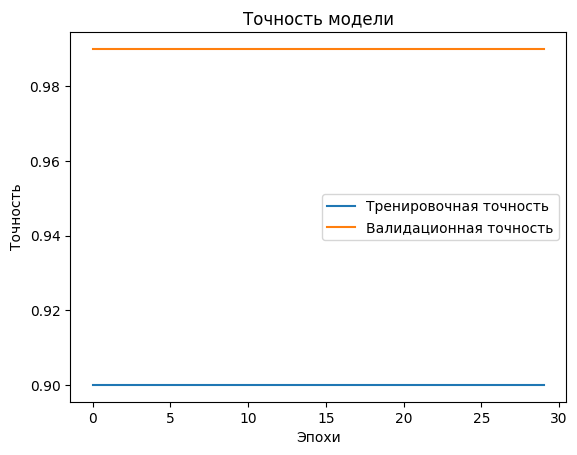

In [122]:
# Визуализация потерь
plt.plot(train_loss, label='Тренировочная потеря')
plt.plot(val_loss, label='Валидационная потеря')
plt.title('Потеря модели')
plt.ylabel('Потеря')
plt.xlabel('Эпохи')
plt.legend()
plt.show()

# Визуализация точности
plt.plot(train_accuracy, label='Тренировочная точность')
plt.plot(val_accuracy, label='Валидационная точность')
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпохи')
plt.legend()
plt.show()


In [123]:
# Получаем предсказания модели
predictions = model.predict(X_test)

# Преобразовываем предсказания в класс
predicted_classes = np.argmax(predictions, axis=-1)  
true_classes = np.argmax(np.array(y_test), axis=-1) 

f1 = f1_score(true_classes.flatten(), predicted_classes.flatten(), average='weighted')
recall = recall_score(true_classes.flatten(), predicted_classes.flatten(), average='weighted')

print('F1 Score:', f1)
print('Recall:', recall)


1/1 [==============================] - 2s 2s/step
F1 Score: 0.6294252873563217
Recall: 0.74


In [124]:
report = classification_report(true_classes.flatten(), predicted_classes.flatten(), zero_division=0)
print("Classification Report \n", report)


Classification Report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        10
           3       0.74      1.00      0.85        74
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         1

    accuracy                           0.74       100
   macro avg       0.09      0.12      0.11       100
weighted avg       0.55      0.74      0.63       100



Результаты практически не изменилсь. Добавление новый слоев, учет весов, увелечение batch_size, увеличения количества эпох, остановке по val_accuracy  не привело к изменениям, модель достаточно обучилась уже на 2 эпохе, но при этом плохо распознает малочисленные классы, скорее всего это происходит из-за того что данных мало, и среди малого количества данных малочисленных классов не хватает для хорошего обучения модели.